In [2]:
from efficient_kan import KAN
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch
import mplhep as hep
hep.style.use("CMS")
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# device = 'cpu'

In [3]:
device

'cuda'

In [2]:
X_train=torch.from_numpy(np.load('data/X_train_val.npy')).float().to(device)
y_train=torch.from_numpy(np.load('data/y_train_val.npy')).float().to(device).argmax(dim=1)
X_test=torch.from_numpy(np.load('data/X_test.npy')).float().to(device)
y_test=torch.from_numpy(np.load('data/y_test.npy')).float().to(device).argmax(dim=1)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64  # Adjust this based on your available memory
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
model = KAN([16,32,5], grid_size=30, spline_order=3, grid_eps=0.05, base_activation=nn.GELU, grid_range=[-2,2])
print(sum(p.numel() for p in model.parameters()))

23520


In [4]:
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [5]:
training_loss = []
testing_loss = []

# Define loss
criterion = nn.CrossEntropyLoss()
for epoch in range(15):
    # Train
    model.train()
    epoch_train_loss = 0  # Initialize loss for the epoch
    total_batches = 0
    with tqdm(trainloader) as pbar:
        for i, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            total_batches += 1

            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
    
    average_train_loss = epoch_train_loss / total_batches
    training_loss.append(average_train_loss)  # Record the average training loss

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            output = model(inputs)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(testloader)
    val_accuracy /= len(testloader)
    testing_loss.append(val_loss)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )

100%|██████████| 10375/10375 [00:17<00:00, 580.13it/s, accuracy=0.703, loss=0.69, lr=0.0001] 


Epoch 1, Val Loss: 0.7169251427594385, Val Accuracy: 0.7445989141762027


100%|██████████| 10375/10375 [00:17<00:00, 586.78it/s, accuracy=0.828, loss=0.54, lr=9e-5] 


Epoch 2, Val Loss: 0.6982240030511857, Val Accuracy: 0.7504497558544853


100%|██████████| 10375/10375 [00:18<00:00, 567.97it/s, accuracy=0.625, loss=0.959, lr=8.1e-5]


Epoch 3, Val Loss: 0.6884874223444952, Val Accuracy: 0.7539373715059888


100%|██████████| 10375/10375 [00:18<00:00, 564.80it/s, accuracy=0.781, loss=0.635, lr=7.29e-5]


Epoch 4, Val Loss: 0.6819961980709041, Val Accuracy: 0.7563287072808539


100%|██████████| 10375/10375 [00:18<00:00, 563.96it/s, accuracy=0.703, loss=0.735, lr=6.56e-5]


Epoch 5, Val Loss: 0.677713661053223, Val Accuracy: 0.7579671035800057


100%|██████████| 10375/10375 [00:18<00:00, 565.00it/s, accuracy=0.75, loss=0.618, lr=5.9e-5] 


Epoch 6, Val Loss: 0.6744829932932864, Val Accuracy: 0.7584489848444622


100%|██████████| 10375/10375 [00:18<00:00, 564.86it/s, accuracy=0.812, loss=0.575, lr=5.31e-5]


Epoch 7, Val Loss: 0.6724234539426651, Val Accuracy: 0.7594187708891807


100%|██████████| 10375/10375 [00:18<00:00, 564.24it/s, accuracy=0.734, loss=0.78, lr=4.78e-5] 


Epoch 8, Val Loss: 0.6704699594007608, Val Accuracy: 0.760013091123003


100%|██████████| 10375/10375 [00:18<00:00, 564.83it/s, accuracy=0.672, loss=0.725, lr=4.3e-5]


Epoch 9, Val Loss: 0.668801875163154, Val Accuracy: 0.7607841011461333


100%|██████████| 10375/10375 [00:18<00:00, 564.87it/s, accuracy=0.781, loss=0.724, lr=3.87e-5]


Epoch 10, Val Loss: 0.6679242351878673, Val Accuracy: 0.7607600070829105


100%|██████████| 10375/10375 [00:18<00:00, 564.67it/s, accuracy=0.734, loss=0.682, lr=3.49e-5]


Epoch 11, Val Loss: 0.6669656911903652, Val Accuracy: 0.7611816531893099


100%|██████████| 10375/10375 [00:18<00:00, 564.80it/s, accuracy=0.766, loss=0.509, lr=3.14e-5]


Epoch 12, Val Loss: 0.6662403909444993, Val Accuracy: 0.7616032992957092


100%|██████████| 10375/10375 [00:18<00:00, 564.71it/s, accuracy=0.766, loss=0.605, lr=2.82e-5]


Epoch 13, Val Loss: 0.6656747127875238, Val Accuracy: 0.7618201458647146


100%|██████████| 10375/10375 [00:18<00:00, 564.85it/s, accuracy=0.734, loss=0.803, lr=2.54e-5]


Epoch 14, Val Loss: 0.6651166519961544, Val Accuracy: 0.7620309689179143


100%|██████████| 10375/10375 [00:18<00:00, 565.54it/s, accuracy=0.656, loss=0.91, lr=2.29e-5] 


Epoch 15, Val Loss: 0.6646379787437532, Val Accuracy: 0.7620671100127485


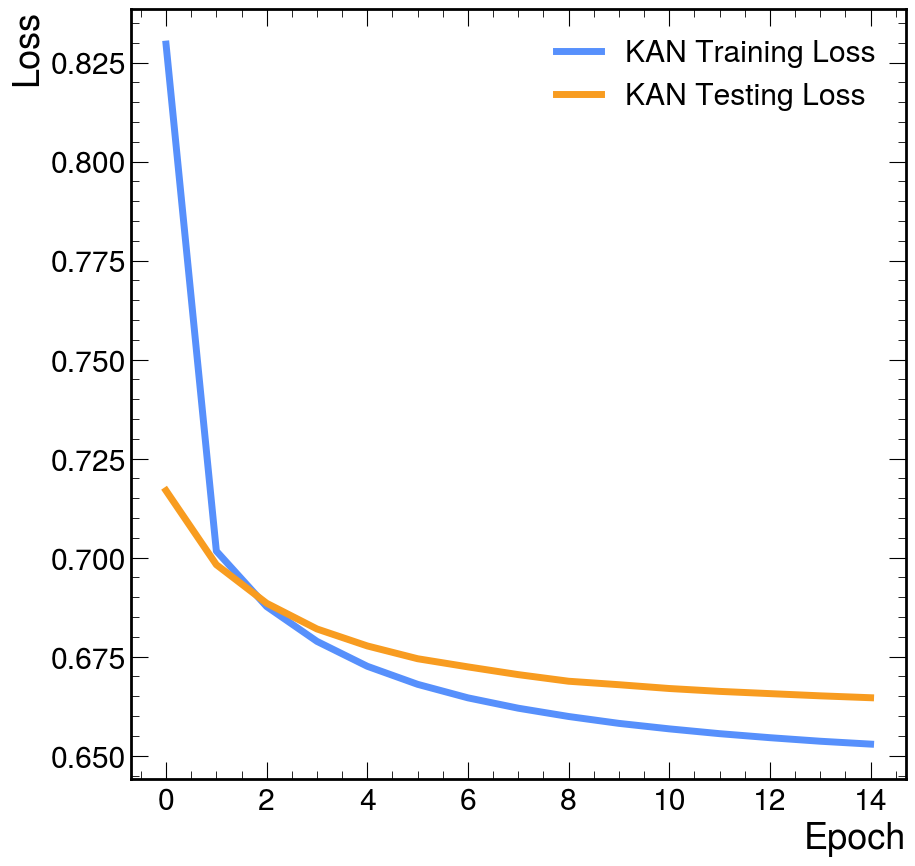

In [6]:
plt.plot(training_loss, label='KAN Training Loss',linewidth=5)
plt.plot(testing_loss, label='KAN Testing Loss',linewidth=5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()